# Kshs-USD Exchange Time Series Forecast

## 1. Import Necessary Libraries

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import nbformat
from tensorflow.keras import layers

## 2. Load Data

In [58]:
# Load the csv file
exchange_data = pd.read_csv('CBK_Indicative_Exchange_Rates.csv')

In [59]:
# Get the last 5 rows of the dataset
exchange_data.tail()

,Date,Currency,Mean,Buy,Sell
4807,12/28/2023,US DOLLAR,156.0941,155.6588,156.5294
4808,12/29/2023,US DOLLAR,156.4618,156.0118,156.9118
4809,1/2/2024,US DOLLAR,156.9853,156.5000,157.4706
4810,1/3/2024,US DOLLAR,157.3235,156.9529,157.6941
4811,1/4/2024,US DOLLAR,157.3912,157.0000,157.7824


In [60]:
# Checking the information of the dataset
exchange_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4812 entries, 0 to 4811
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      4812 non-null   object 
 1   Currency  4812 non-null   object 
 2   Mean      4812 non-null   float64
 3   Buy       4812 non-null   float64
 4   Sell      4812 non-null   float64
dtypes: float64(3), object(2)
memory usage: 188.1+ KB


In [61]:
exchange_data.drop(columns='Currency', inplace=True)

## 3. Data Cleaning

In [62]:
# Converting the Date column data type to DateTime

try:
    exchange_data['Date'] = pd.to_datetime(exchange_data['Date'], errors='coerce')
except ValueError:
    print("Error: Unable to parse dates. Please check the format of your date strings.")


In [63]:
exchange_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4812 entries, 0 to 4811
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    4812 non-null   datetime64[ns]
 1   Mean    4812 non-null   float64       
 2   Buy     4812 non-null   float64       
 3   Sell    4812 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 150.5 KB


## 4. Time Series Analysis

### 4.1 Mean Distribution

<Axes: xlabel='Mean'>

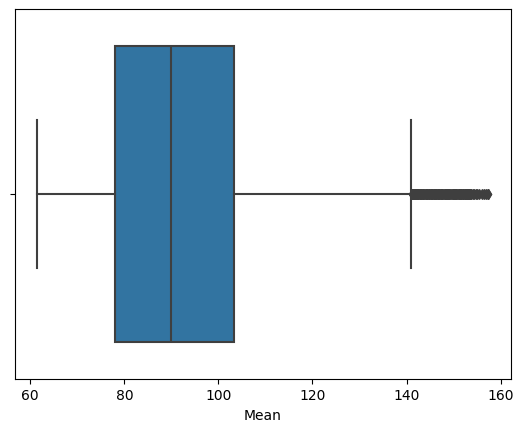

In [64]:
sns.boxplot(data=exchange_data, x='Mean', orient='h')

From the box plot, it is clear that there are outliers all the way to 160 in the mean column. The median is 90 while maximum and minimum are 140 and 60 respectively.

### 4.2 Exchange Rate per Date

In [65]:

# Create an interactive line plot with Plotly
fig = px.line(exchange_data, x='Date', y='Mean', labels={'Mean': 'Mean Exchange Rate'})
fig.update_traces(mode='lines+markers', hovertemplate=None)
fig.update_layout(hovermode='x unified',
                  hoverlabel=dict(bgcolor="white", font_size=12, font_family="Arial"),
                  title='Mean Exchange Rate(USD/KSH) Over Time',
                  xaxis_title='Date',
                  yaxis_title='Mean Exchange Rate',
                  xaxis=dict(showgrid=False))  # Hide date markers on the x-axis
fig.show()


After Kenya's 2007-2008 PEV, the Kshs drastically weakened over the dollar. 

### 4.3 Exchange Rate (Buy) per Year

In [66]:
# Create an interactive line plot with Plotly
fig = px.line(exchange_data, x='Date', y='Buy', labels={'Mean': 'Mean Exchange Rate'})
fig.update_traces(mode='lines+markers', hovertemplate=None)
fig.update_layout(hovermode='x unified',
                  hoverlabel=dict(bgcolor="white", font_size=12, font_family="Arial"),
                  title='Buy Exchange Rate(USD/KSH) Over Time',
                  xaxis_title='Date',
                  yaxis_title='Mean Exchange Rate',
                  xaxis=dict(showgrid=False))  # Hide date markers on the x-axis
fig.show()

In [67]:
# Create an interactive line plot with Plotly
fig = px.line(exchange_data, x='Date', y='Sell', labels={'Mean': 'Mean Exchange Rate'})
fig.update_traces(mode='lines+markers', hovertemplate=None)
fig.update_layout(hovermode='x unified',
                  hoverlabel=dict(bgcolor="white", font_size=12, font_family="Arial"),
                  title='Sell Exchange Rate(USD/KSH) Over Time',
                  xaxis_title='Date',
                  yaxis_title='Mean Exchange Rate',
                  xaxis=dict(showgrid=False))  # Hide date markers on the x-axis
fig.show()

## 5. Time Series Forecasting

### 5.1 Data Normalization
This will entail scaling of the data values from 0 to using sklearn.MinMaxScaler() and later reshaping the dataset to be able to fit into the RNN network.

In [68]:

# normalize the dataset
from sklearn.preprocessing import MinMaxScaler

# Identify numerical columns excluding the 'Date' column
numerical_columns = exchange_data.select_dtypes(include=['float64', 'int64']).columns
  # Exclude the 'Date' and 'Mean' column
# Initialize the StandardScaler
scaler = MinMaxScaler()

# Standardize the numerical features
exchange_data[numerical_columns] = scaler.fit_transform(exchange_data[numerical_columns])

# Verify the standardized data
print(exchange_data.head())


        Date      Mean       Buy      Sell
0 2003-09-12  0.236103  0.236655  0.235557
1 2004-09-12  0.237902  0.238445  0.237364
2 2004-09-12  0.237902  0.238445  0.237364
3 2004-11-02  0.205435  0.205825  0.205047
4 2004-11-03  0.205475  0.205894  0.205059


### 5.2 Reshape Data

In [69]:
# Convert the dataset into sequences suitable for training an LSTM model
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Define sequence length (number of time steps)
seq_length = 3  # Adjust according to your requirement

# Apply create_sequences function to 'Mean' column
X, y = create_sequences(exchange_data['Mean'].values, seq_length)


### 5.2 Split the Dataset

In [70]:
# Split the Dataset
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

# Reshape input data for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


## 6. Model Creation

In [71]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense 


### 6.1 Building the Nueral Network

In [72]:
# Building the neural network

model = tf.keras.Sequential()

model.add(layers.LSTM(units=32, return_sequences=True,
                  input_shape=(3,1), dropout=0.2))

model.add(layers.LSTM(units=32, return_sequences=True,
                  dropout=0.2))

model.add(layers.LSTM(units=32, dropout=0.2))

model.add(layers.Dense(units=1))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 3, 32)             4352      
                                                                 
 lstm_7 (LSTM)               (None, 3, 32)             8320      
                                                                 
 lstm_8 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21025 (82.13 KB)
Trainable params: 21025 (82.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 6.2 Compile the Model

In [73]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

### 6.3 Train the Model

In [74]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
121/121 [==============================] - 13s 26ms/step - loss: 0.0290 - val_loss: 0.0046
Epoch 2/10
121/121 [==============================] - 1s 10ms/step - loss: 0.0113 - val_loss: 0.0041
Epoch 3/10
121/121 [==============================] - 1s 11ms/step - loss: 0.0108 - val_loss: 0.0043
Epoch 4/10
121/121 [==============================] - 1s 11ms/step - loss: 0.0097 - val_loss: 0.0034
Epoch 5/10
121/121 [==============================] - 1s 10ms/step - loss: 0.0081 - val_loss: 0.0031
Epoch 6/10
121/121 [==============================] - 1s 10ms/step - loss: 0.0048 - val_loss: 0.0056
Epoch 7/10
121/121 [==============================] - 1s 10ms/step - loss: 0.0037 - val_loss: 0.0041
Epoch 8/10
121/121 [==============================] - 1s 12ms/step - loss: 0.0033 - val_loss: 0.0052
Epoch 9/10
121/121 [==============================] - 1s 10ms/step - loss: 0.0023 - val_loss: 0.0051
Epoch 10/10
121/121 [==============================] - 1s 10ms/step - loss: 0.0025 - val_l

### 6.4 Plot training and validation loss

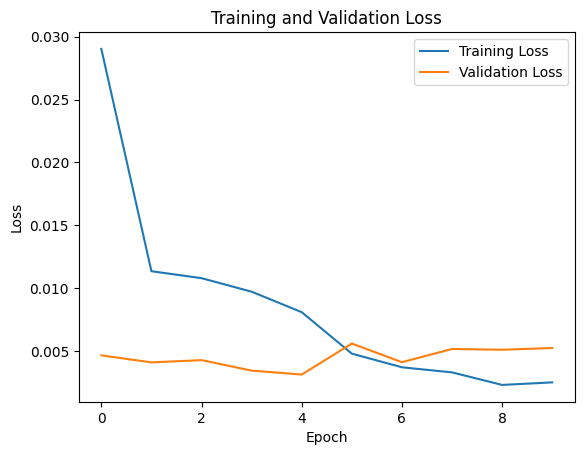

In [75]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### 6.5 Predictions and Accuracy

In [76]:

# Make predictions
predictions = model.predict(X_test)

# Calculate accuracy (e.g., Mean Absolute Error)
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error:", mae)

31/31 [==============================] - 2s 5ms/step
Mean Absolute Error: 0.06082731363274862


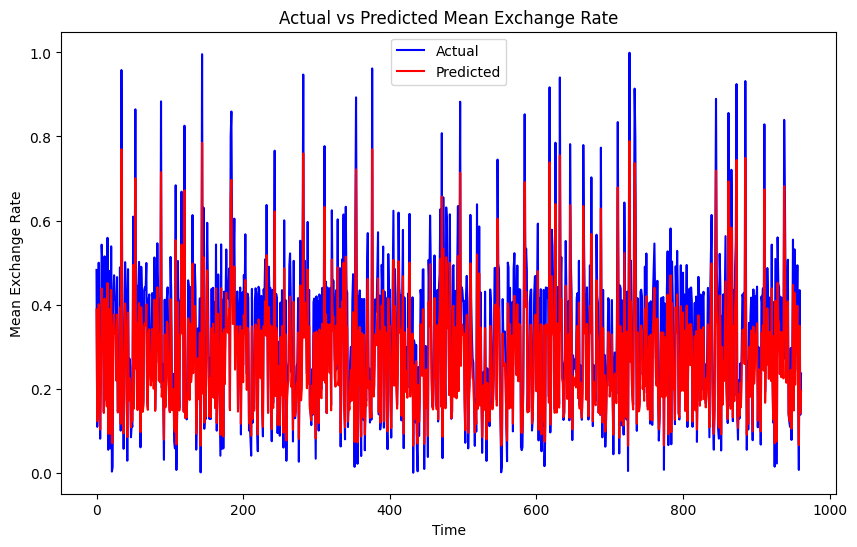

In [79]:
# Visualize actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(predictions, label='Predicted', color='red')
plt.title('Actual vs Predicted Mean Exchange Rate')
plt.xlabel('Time')
plt.ylabel('Mean Exchange Rate')
plt.legend()
plt.show()